In [1]:
import tensorflow as tf
import numpy as np
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import utils
from augmentation import augmentation
from pointnet import PointNet_vanilla

In [2]:
category_names = utils.get_category_names()
train_dateset_paths = utils.get_dataset_paths('train_files.txt')
test_dateset_paths = utils.get_dataset_paths('test_files.txt')

n_classes = len(category_names)
n_pts = 2048

In [3]:
with tf.device('/device:GPU:0'):
    x = tf.placeholder(tf.float32, shape=[None, n_pts, 3], name='x') # Data Points
    y = tf.placeholder(tf.int32, shape=[None], name='y') # Labels
    learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate') # Adaptive learning rate
    bn_decay = tf.placeholder(tf.float32, shape=[], name='bn_decay') # Adaptive batch norm decay rate
    is_training =tf.placeholder(tf.bool , shape=[], name='is_training') # Training phrase
    
# Point Net Vanilla
preds = PointNet_vanilla(x, n_pts, n_classes, bn_decay=bn_decay, is_training=is_training)

cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=preds)) # cost function

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9).minimize(cost) # adam optimizer - update ops

evaluate = tf.equal(tf.argmax(preds, axis=1, output_type=tf.int32), y) # equivalent to provided utils.evaluate
accuracy = tf.reduce_mean(tf.cast(evaluate, tf.float32))

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.log_device_placement=True

batch_size = 32
n_epoch = 300
lr = 1e-3
decay = 0.5

test_every = 30
halve_lr_every = 20
increase_decay_every = 20

In [5]:
all_losses = []
init = tf.global_variables_initializer()

with tf.device('/device:GPU:0'):
    sess = tf.InteractiveSession(config = config)
    sess.run(init)
    start_time = time.time()

    for epoch in range(n_epoch):

        for datapath in train_dateset_paths:
            train_data, train_label = utils.load_h5(datapath)
            train_data, train_label, n_batch = utils.create_batch(train_data, train_label, batch_size)
            total_loss = 0.

            for i in range(n_batch):
                _, loss = sess.run([optimizer, cost], \
                                   feed_dict={x:augmentation(train_data[i]), y:train_label[i], \
                                              learning_rate:lr, bn_decay:decay, is_training:True})
                total_loss += loss

            total_loss /= train_data.shape[0]
            all_losses.append(total_loss)
            uptime = time.time() - start_time
            print('%dm:%ds -- [%d, %s], loss: %f' % \
                  (uptime/60, uptime%60, epoch, datapath, total_loss))

        if (epoch + 1) % halve_lr_every:
            lr /= 2
        
        if (epoch + 1) % increase_decay_every:
            decay += 0.1
            decay = 0.99 if decay > 0.99 else decay
            
        if (epoch + 1) % test_every == 0:
            print('\n')
            for datapath in test_dateset_paths:
                val_data, val_label = utils.create_val(datapath)
                print('Test %s accuracy:' % (datapath), \
                      accuracy.eval(feed_dict={x:val_data, y:val_label.reshape(-1),\
                                               bn_decay:decay, is_training:True}))
            print('\n')

0m:5s -- [0, ply_data_train0.h5], loss: 2.256237
0m:9s -- [0, ply_data_train1.h5], loss: 1.476163
0m:14s -- [0, ply_data_train2.h5], loss: 1.242268
0m:18s -- [0, ply_data_train3.h5], loss: 1.098482
0m:21s -- [0, ply_data_train4.h5], loss: 1.058537
0m:26s -- [1, ply_data_train0.h5], loss: 0.998253
0m:30s -- [1, ply_data_train1.h5], loss: 0.906424
0m:34s -- [1, ply_data_train2.h5], loss: 0.907458
0m:39s -- [1, ply_data_train3.h5], loss: 0.767460
0m:42s -- [1, ply_data_train4.h5], loss: 0.762878
0m:46s -- [2, ply_data_train0.h5], loss: 0.770632
0m:50s -- [2, ply_data_train1.h5], loss: 0.697530
0m:55s -- [2, ply_data_train2.h5], loss: 0.714035
0m:59s -- [2, ply_data_train3.h5], loss: 0.753000
1m:2s -- [2, ply_data_train4.h5], loss: 0.643517
1m:7s -- [3, ply_data_train0.h5], loss: 0.702332
1m:11s -- [3, ply_data_train1.h5], loss: 0.675701
1m:15s -- [3, ply_data_train2.h5], loss: 0.654073
1m:19s -- [3, ply_data_train3.h5], loss: 0.579822
1m:23s -- [3, ply_data_train4.h5], loss: 0.585975
1m:2

11m:6s -- [32, ply_data_train1.h5], loss: 0.546396
11m:10s -- [32, ply_data_train2.h5], loss: 0.506185
11m:14s -- [32, ply_data_train3.h5], loss: 0.505165
11m:18s -- [32, ply_data_train4.h5], loss: 0.524388
11m:22s -- [33, ply_data_train0.h5], loss: 0.544427
11m:26s -- [33, ply_data_train1.h5], loss: 0.560865
11m:31s -- [33, ply_data_train2.h5], loss: 0.546932
11m:35s -- [33, ply_data_train3.h5], loss: 0.498461
11m:38s -- [33, ply_data_train4.h5], loss: 0.500151
11m:43s -- [34, ply_data_train0.h5], loss: 0.593398
11m:47s -- [34, ply_data_train1.h5], loss: 0.560327
11m:51s -- [34, ply_data_train2.h5], loss: 0.523196
11m:56s -- [34, ply_data_train3.h5], loss: 0.515304
11m:59s -- [34, ply_data_train4.h5], loss: 0.455842
12m:3s -- [35, ply_data_train0.h5], loss: 0.545158
12m:7s -- [35, ply_data_train1.h5], loss: 0.548617
12m:12s -- [35, ply_data_train2.h5], loss: 0.525834
12m:16s -- [35, ply_data_train3.h5], loss: 0.470824
12m:19s -- [35, ply_data_train4.h5], loss: 0.505915
12m:24s -- [36,

21m:51s -- [63, ply_data_train3.h5], loss: 0.504901
21m:54s -- [63, ply_data_train4.h5], loss: 0.484443
21m:58s -- [64, ply_data_train0.h5], loss: 0.521801
22m:3s -- [64, ply_data_train1.h5], loss: 0.536547
22m:7s -- [64, ply_data_train2.h5], loss: 0.535276
22m:11s -- [64, ply_data_train3.h5], loss: 0.481750
22m:15s -- [64, ply_data_train4.h5], loss: 0.480641
22m:19s -- [65, ply_data_train0.h5], loss: 0.542806
22m:23s -- [65, ply_data_train1.h5], loss: 0.580118
22m:27s -- [65, ply_data_train2.h5], loss: 0.586747
22m:32s -- [65, ply_data_train3.h5], loss: 0.470271
22m:35s -- [65, ply_data_train4.h5], loss: 0.470895
22m:39s -- [66, ply_data_train0.h5], loss: 0.570736
22m:44s -- [66, ply_data_train1.h5], loss: 0.573972
22m:48s -- [66, ply_data_train2.h5], loss: 0.528331
22m:52s -- [66, ply_data_train3.h5], loss: 0.467289
22m:56s -- [66, ply_data_train4.h5], loss: 0.457065
23m:0s -- [67, ply_data_train0.h5], loss: 0.555697
23m:4s -- [67, ply_data_train1.h5], loss: 0.575463
23m:9s -- [67, p

32m:34s -- [95, ply_data_train0.h5], loss: 0.536188
32m:39s -- [95, ply_data_train1.h5], loss: 0.602238
32m:43s -- [95, ply_data_train2.h5], loss: 0.517408
32m:47s -- [95, ply_data_train3.h5], loss: 0.513476
32m:50s -- [95, ply_data_train4.h5], loss: 0.476991
32m:55s -- [96, ply_data_train0.h5], loss: 0.569190
32m:59s -- [96, ply_data_train1.h5], loss: 0.559271
33m:3s -- [96, ply_data_train2.h5], loss: 0.592497
33m:7s -- [96, ply_data_train3.h5], loss: 0.459435
33m:11s -- [96, ply_data_train4.h5], loss: 0.563707
33m:15s -- [97, ply_data_train0.h5], loss: 0.541728
33m:19s -- [97, ply_data_train1.h5], loss: 0.553954
33m:23s -- [97, ply_data_train2.h5], loss: 0.512890
33m:28s -- [97, ply_data_train3.h5], loss: 0.482075
33m:31s -- [97, ply_data_train4.h5], loss: 0.435734
33m:35s -- [98, ply_data_train0.h5], loss: 0.581718
33m:40s -- [98, ply_data_train1.h5], loss: 0.553796
33m:44s -- [98, ply_data_train2.h5], loss: 0.571036
33m:48s -- [98, ply_data_train3.h5], loss: 0.521125
33m:52s -- [98

43m:5s -- [125, ply_data_train4.h5], loss: 0.493017
43m:9s -- [126, ply_data_train0.h5], loss: 0.584872
43m:14s -- [126, ply_data_train1.h5], loss: 0.540972
43m:18s -- [126, ply_data_train2.h5], loss: 0.555989
43m:22s -- [126, ply_data_train3.h5], loss: 0.519902
43m:26s -- [126, ply_data_train4.h5], loss: 0.492259
43m:30s -- [127, ply_data_train0.h5], loss: 0.527597
43m:34s -- [127, ply_data_train1.h5], loss: 0.625599
43m:38s -- [127, ply_data_train2.h5], loss: 0.530350
43m:43s -- [127, ply_data_train3.h5], loss: 0.504773
43m:46s -- [127, ply_data_train4.h5], loss: 0.496599
43m:50s -- [128, ply_data_train0.h5], loss: 0.560832
43m:55s -- [128, ply_data_train1.h5], loss: 0.534341
43m:59s -- [128, ply_data_train2.h5], loss: 0.554565
44m:3s -- [128, ply_data_train3.h5], loss: 0.481005
44m:7s -- [128, ply_data_train4.h5], loss: 0.486047
44m:11s -- [129, ply_data_train0.h5], loss: 0.579677
44m:15s -- [129, ply_data_train1.h5], loss: 0.583329
44m:19s -- [129, ply_data_train2.h5], loss: 0.4953

53m:38s -- [156, ply_data_train3.h5], loss: 0.463307
53m:42s -- [156, ply_data_train4.h5], loss: 0.414341
53m:46s -- [157, ply_data_train0.h5], loss: 0.625415
53m:50s -- [157, ply_data_train1.h5], loss: 0.508026
53m:55s -- [157, ply_data_train2.h5], loss: 0.496572
54m:0s -- [157, ply_data_train3.h5], loss: 0.542817
54m:3s -- [157, ply_data_train4.h5], loss: 0.507615
54m:8s -- [158, ply_data_train0.h5], loss: 0.552555
54m:13s -- [158, ply_data_train1.h5], loss: 0.545287
54m:17s -- [158, ply_data_train2.h5], loss: 0.528152
54m:22s -- [158, ply_data_train3.h5], loss: 0.510503
54m:25s -- [158, ply_data_train4.h5], loss: 0.519358
54m:30s -- [159, ply_data_train0.h5], loss: 0.598916
54m:34s -- [159, ply_data_train1.h5], loss: 0.614223
54m:39s -- [159, ply_data_train2.h5], loss: 0.579985
54m:44s -- [159, ply_data_train3.h5], loss: 0.536525
54m:48s -- [159, ply_data_train4.h5], loss: 0.468608
54m:52s -- [160, ply_data_train0.h5], loss: 0.542835
54m:57s -- [160, ply_data_train1.h5], loss: 0.556

64m:51s -- [187, ply_data_train2.h5], loss: 0.497126
64m:55s -- [187, ply_data_train3.h5], loss: 0.540721
64m:59s -- [187, ply_data_train4.h5], loss: 0.495460
65m:3s -- [188, ply_data_train0.h5], loss: 0.548418
65m:7s -- [188, ply_data_train1.h5], loss: 0.533643
65m:12s -- [188, ply_data_train2.h5], loss: 0.519187
65m:16s -- [188, ply_data_train3.h5], loss: 0.472418
65m:19s -- [188, ply_data_train4.h5], loss: 0.443282
65m:23s -- [189, ply_data_train0.h5], loss: 0.518343
65m:28s -- [189, ply_data_train1.h5], loss: 0.543802
65m:32s -- [189, ply_data_train2.h5], loss: 0.510224
65m:36s -- [189, ply_data_train3.h5], loss: 0.487670
65m:40s -- [189, ply_data_train4.h5], loss: 0.478715
65m:44s -- [190, ply_data_train0.h5], loss: 0.523192
65m:48s -- [190, ply_data_train1.h5], loss: 0.586840
65m:53s -- [190, ply_data_train2.h5], loss: 0.537404
65m:57s -- [190, ply_data_train3.h5], loss: 0.535563
66m:0s -- [190, ply_data_train4.h5], loss: 0.492836
66m:4s -- [191, ply_data_train0.h5], loss: 0.5528

75m:35s -- [218, ply_data_train1.h5], loss: 0.525269
75m:39s -- [218, ply_data_train2.h5], loss: 0.549267
75m:43s -- [218, ply_data_train3.h5], loss: 0.496771
75m:47s -- [218, ply_data_train4.h5], loss: 0.546302
75m:51s -- [219, ply_data_train0.h5], loss: 0.582661
75m:55s -- [219, ply_data_train1.h5], loss: 0.562068
75m:59s -- [219, ply_data_train2.h5], loss: 0.535262
76m:4s -- [219, ply_data_train3.h5], loss: 0.462007
76m:7s -- [219, ply_data_train4.h5], loss: 0.527224
76m:11s -- [220, ply_data_train0.h5], loss: 0.586759
76m:16s -- [220, ply_data_train1.h5], loss: 0.569705
76m:20s -- [220, ply_data_train2.h5], loss: 0.484695
76m:24s -- [220, ply_data_train3.h5], loss: 0.531796
76m:27s -- [220, ply_data_train4.h5], loss: 0.497244
76m:32s -- [221, ply_data_train0.h5], loss: 0.585187
76m:36s -- [221, ply_data_train1.h5], loss: 0.595799
76m:40s -- [221, ply_data_train2.h5], loss: 0.533892
76m:45s -- [221, ply_data_train3.h5], loss: 0.469467
76m:48s -- [221, ply_data_train4.h5], loss: 0.49

86m:8s -- [249, ply_data_train0.h5], loss: 0.582576
86m:12s -- [249, ply_data_train1.h5], loss: 0.572196
86m:16s -- [249, ply_data_train2.h5], loss: 0.528604
86m:20s -- [249, ply_data_train3.h5], loss: 0.513055
86m:24s -- [249, ply_data_train4.h5], loss: 0.471077
86m:28s -- [250, ply_data_train0.h5], loss: 0.575006
86m:32s -- [250, ply_data_train1.h5], loss: 0.554635
86m:37s -- [250, ply_data_train2.h5], loss: 0.530978
86m:41s -- [250, ply_data_train3.h5], loss: 0.477951
86m:44s -- [250, ply_data_train4.h5], loss: 0.464371
86m:49s -- [251, ply_data_train0.h5], loss: 0.568524
86m:53s -- [251, ply_data_train1.h5], loss: 0.562514
86m:57s -- [251, ply_data_train2.h5], loss: 0.537439
87m:2s -- [251, ply_data_train3.h5], loss: 0.456774
87m:5s -- [251, ply_data_train4.h5], loss: 0.516124
87m:9s -- [252, ply_data_train0.h5], loss: 0.582221
87m:14s -- [252, ply_data_train1.h5], loss: 0.551770
87m:18s -- [252, ply_data_train2.h5], loss: 0.508289
87m:22s -- [252, ply_data_train3.h5], loss: 0.4697

96m:42s -- [279, ply_data_train4.h5], loss: 0.519290
96m:46s -- [280, ply_data_train0.h5], loss: 0.582553
96m:51s -- [280, ply_data_train1.h5], loss: 0.565159
96m:55s -- [280, ply_data_train2.h5], loss: 0.532302
96m:59s -- [280, ply_data_train3.h5], loss: 0.516845
97m:2s -- [280, ply_data_train4.h5], loss: 0.488579
97m:7s -- [281, ply_data_train0.h5], loss: 0.569496
97m:11s -- [281, ply_data_train1.h5], loss: 0.575145
97m:15s -- [281, ply_data_train2.h5], loss: 0.555579
97m:20s -- [281, ply_data_train3.h5], loss: 0.521351
97m:23s -- [281, ply_data_train4.h5], loss: 0.467718
97m:27s -- [282, ply_data_train0.h5], loss: 0.524334
97m:32s -- [282, ply_data_train1.h5], loss: 0.540002
97m:36s -- [282, ply_data_train2.h5], loss: 0.511910
97m:40s -- [282, ply_data_train3.h5], loss: 0.536996
97m:44s -- [282, ply_data_train4.h5], loss: 0.463843
97m:48s -- [283, ply_data_train0.h5], loss: 0.519156
97m:52s -- [283, ply_data_train1.h5], loss: 0.536726
97m:57s -- [283, ply_data_train2.h5], loss: 0.51

In [7]:
saver = tf.train.Saver()
saver.save(sess, "model/PointNet_vanilla_300epoch.ckpt")
sess.close()

In [17]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "model/PointNet_vanilla_300epoch.ckpt")
    print('\n\nAfter Training:')

    for datapath in train_dateset_paths:
        train_data, train_label = utils.create_val(datapath)
        print('Train %s accuracy:' % (datapath), \
          accuracy.eval(feed_dict={x:train_data, y:train_label.reshape(-1),\
                                   bn_decay:0.99, is_training:False}))

    for datapath in test_dateset_paths:
        test_data, test_label = utils.create_val(datapath)
        print('Test %s accuracy:' % (datapath), \
          accuracy.eval(feed_dict={x:test_data, y:test_label.reshape(-1),\
                                   bn_decay:0.99, is_training:False}))

INFO:tensorflow:Restoring parameters from model/PointNet_vanilla_300epoch.ckpt


After Training:
Train ply_data_train0.h5 accuracy: 0.901961
Train ply_data_train1.h5 accuracy: 0.921569
Train ply_data_train2.h5 accuracy: 0.921569
Train ply_data_train3.h5 accuracy: 0.911765
Train ply_data_train4.h5 accuracy: 0.939024
Test ply_data_test0.h5 accuracy: 0.862745
Test ply_data_test1.h5 accuracy: 0.904762


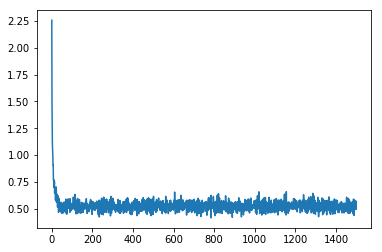

In [8]:
plt.figure()
plt.plot(all_losses)